# SQL-Python Project

OBJECTIVE :This project aims to analyze and answer key business questions about a fictional music record store called Chinook.

Tasks Performed : Extracting required data from database using complex SQL queries, running queries in python and visualizing data in python

Tools used : SQL, Python

In [16]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image
%matplotlib inline

In [17]:
#run_query(q): Takes a SQL query as an argument and returns a pandas dataframe by using the connection as a SQLite built-in context manager. 
def run_query(q):
    with sqlite3.connect(r"C:\Users\Arun\Desktop\Python\SQL\SQL-Python\chinook.db") as conn:
        return pd.read_sql_query(q, conn)

In [18]:
#run_command(c): Takes a SQL command as an argument and executes it using the sqlite module.
def run_command(c):
    with sqlite3.connect(r"C:\Users\Arun\Desktop\Python\SQL\SQL-Python\chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)

In [19]:
def show_tables():
    q = '''SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)    

# Database

In [20]:
print("Tables : \n")
show_tables()

Tables : 



,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The schema diagram for the Chinook database looks like the following:

Relational Schema : 



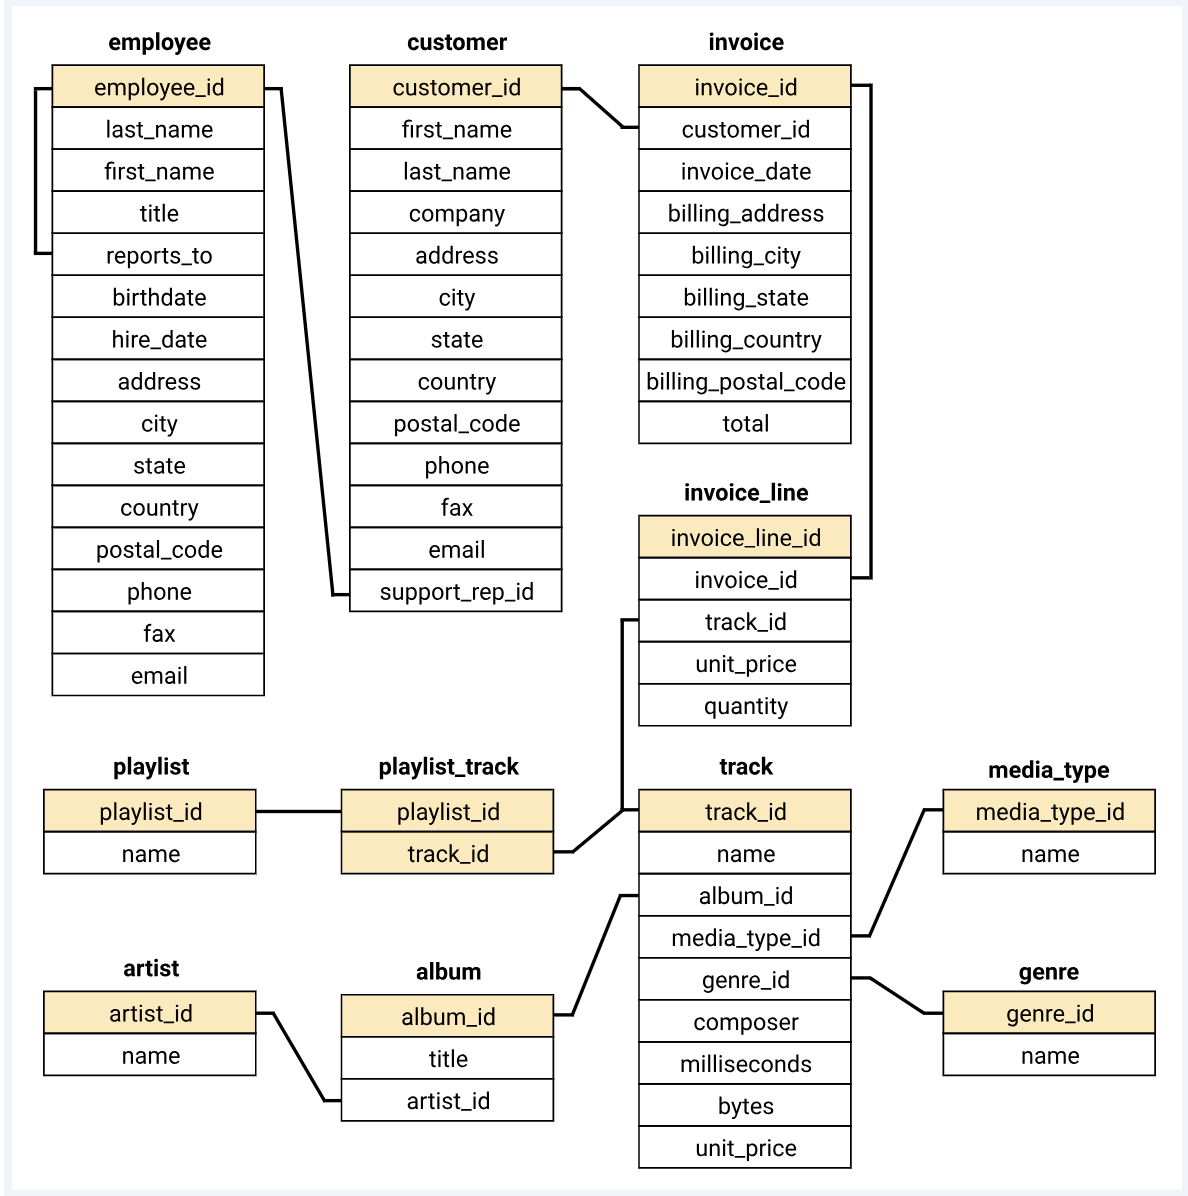

In [21]:
print("Relational Schema : \n")
Image(filename=r"C:\Users\Arun\Desktop\Python\SQL\SQL-Python\datasets_83465_193749_schema_diagram.png")

# Analysis

# Top Selling Genres in USA?

The first question to answer comes from the hypothetical situation where a record label asks the music store to promote its artits, and so it needs to find out which genres sell the most tracks in the USA, in order for them to select one artist or another.

In [22]:
 q1 = """WITH usa_tracks_sold AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = 'USA'
   )
SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC"""
    
genre_sales_usa = run_query(q1)
print("Top 10 genres sold in USA : \n")
genre_sales_usa.head(10)

Top 10 genres sold in USA : 



,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


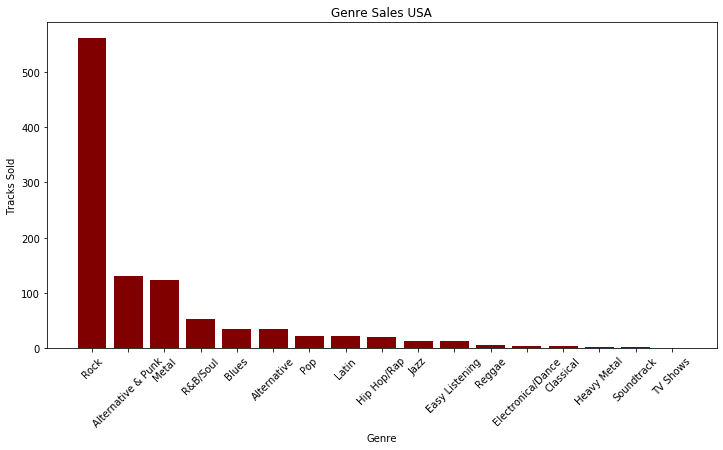

In [23]:
x = genre_sales_usa["genre"]
height = genre_sales_usa["tracks_sold"]
fig = plt.figure(figsize = (12,6))
plt.bar(x = x, height = height, color = "maroon")
plt.title("Genre Sales USA")
plt.xlabel("Genre")
plt.ylabel("Tracks Sold")
plt.xticks(rotation=45)
plt.show()

# Total Sales per agent ?


Analyzing the purchases of customers belonging to each employee will show if any sales support agent is performing either better or worse than the others.

In [24]:
q2 = '''SELECT 
      e.first_name || " " || e.last_name employee_name,
      e.hire_date hire_date,
      SUM(i.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY employee_name
ORDER BY total_sales DESC'''

sales_per_agent = run_query(q2)
sales_per_agent

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


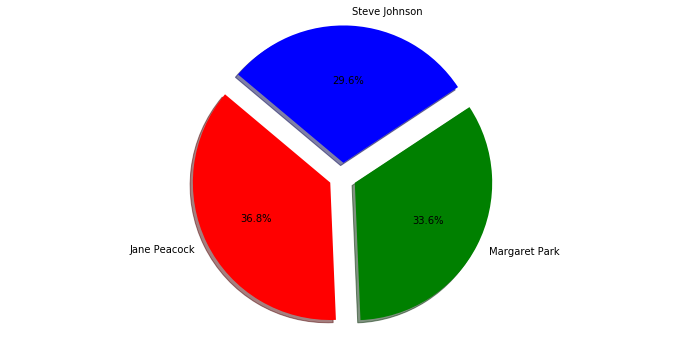

In [25]:
labels = sales_per_agent["employee_name"]
sizes = sales_per_agent["total_sales"]
colors = ["red", "green", "blue"]
explode = [0.1,0.1,0.1]
fig = plt.figure(figsize = (12,6))
plt.pie(sizes, explode =explode, labels = labels, colors = colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis("equal")
plt.show()

# Sales By Country

Analyzing sales by country will tell the company which ones may have potential for growth

In [26]:
q3 = '''WITH country_wise_stats2 AS 
(
    WITH country_wise_stats AS 
    (
    WITH country_wise_sales AS 
        (
       SELECT 
       c.country country,
       SUM(i.total) total_sales,
       COUNT(DISTINCT c.customer_id) total_customer,
       SUM(i.total)/COUNT(DISTINCT c.customer_id) avg_sales_per_customer,
       COUNT(i.invoice_id) total_orders,
       SUM(i.total)/COUNT(i.invoice_id) avg_order_value
FROM customer c
INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY c.country       
                            )
SELECT 
     CASE 
         WHEN total_customer = 1 THEN "Others"
         ELSE country
         END AS country,
     SUM(total_sales) total_sales,
     SUM(total_customer) total_customer,
     SUM(total_sales)/SUM(total_customer) avg_sales_per_customer,
     SUM(total_orders) total_orders,
     SUM(total_sales)/SUM(total_orders) avg_order_value
FROM country_wise_sales
GROUP BY 1
ORDER BY total_sales DESC)
SELECT *,
      CASE 
      WHEN country = "Others" THEN 1
      ELSE 0 
      END AS sort
FROM country_wise_stats
ORDER BY sort)
SELECT 
      country,
      total_sales,
      total_customer,
      avg_sales_per_customer,
      total_orders,
      avg_order_value
FROM country_wise_stats2'''

sales_by_country = run_query(q3)
sales_by_country

,country,total_sales,total_customer,avg_sales_per_customer,total_orders,avg_order_value
0,USA,1040.49,13,80.037692,131,7.942672
1,Canada,535.59,8,66.948750,76,7.047237
2,Brazil,427.68,5,85.536000,61,7.011148
3,France,389.07,5,77.814000,50,7.781400
4,Germany,334.62,4,83.655000,41,8.161463
5,Czech Republic,273.24,2,136.620000,30,9.108000
6,United Kingdom,245.52,3,81.840000,28,8.768571
7,Portugal,185.13,2,92.565000,29,6.383793
8,India,183.15,2,91.575000,21,8.721429
9,Others,1094.94,15,72.996000,147,7.448571


C:\Users\Arun\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


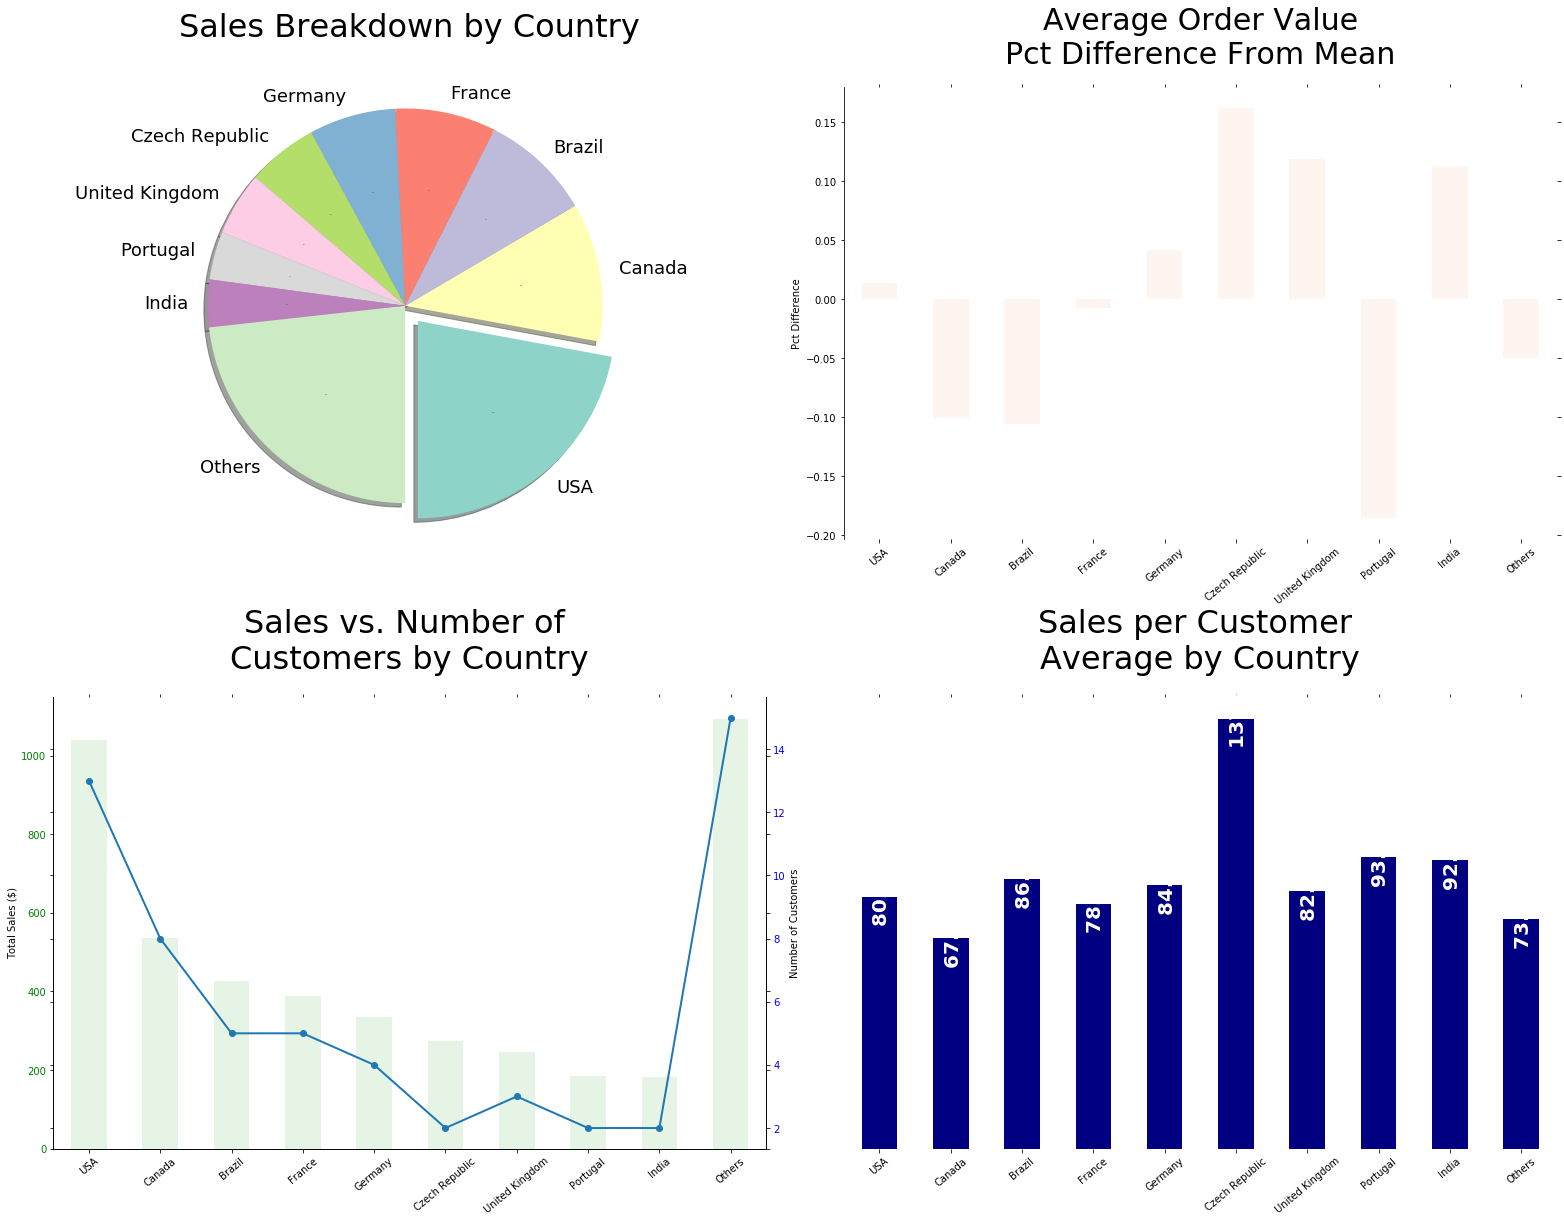

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22,17))
ax1, ax2, ax3, ax4 = axes.flatten()

#Top left axis
countries = sales_by_country['country'].tolist()
amounts = sales_by_country['total_sales'].tolist()
percentage_sales = np.array(amounts)/sum(amounts)
colors = cm.Set3(np.arange(10)/10.)
explode = [0]*10
explode[0] = 0.1

patches, texts, autotexts = ax1.pie(percentage_sales, 
                                    colors=colors, 
                                    labels=countries, 
                                    autopct='%1.1f%%',
                                    explode=explode,
                                    startangle=-90,
                                    shadow=True)

for i in range(0,10):
    texts[i].set_fontsize(18)
    autotexts[i].set_fontsize(0)
    
ax1.set_title('Sales Breakdown by Country', fontsize=32, y=1.1)
ax1.axis('equal') 



#Top right axis
mean_value_orders = sales_by_country['avg_order_value'].mean()
sales_by_country_copy = sales_by_country[['country', 'avg_order_value']]
differences = sales_by_country_copy['avg_order_value'] - mean_value_orders 
sales_by_country_copy['percentage_difference'] = differences/mean_value_orders
    
    
sales_by_country_copy.plot.bar(x='country', 
                               y='percentage_difference', 
                               ax=ax2, 
                               colormap=plt.cm.Reds,
                               width=0.5,
                               legend=False,
                               rot=40)

ax2.set_xlabel('')
ax2.set_ylabel('Pct Difference')
ax2.set_title('Average Order Value\nPct Difference From Mean', fontsize=30, y=1.04)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)



#Bottom left axis
ax_overlap = ax3.twinx()

sales_by_country.plot.bar(x='country', 
                         y='total_sales', 
                         ax=ax3, 
                         colormap=plt.cm.Accent,
                         width=0.5,
                         legend=False,
                         alpha=0.2,
                         rot=40)

ax_overlap.plot(sales_by_country['total_customer'], lw=2,marker='o')

ax3.set_title('Sales vs. Number of \nCustomers by Country', fontsize=32, y=1.05)
ax3.set_ylabel('Total Sales ($)')
ax_overlap.set_ylabel('Number of Customers')
ax3.set_xlabel('')
ax3.spines["top"].set_visible(False)
ax_overlap.spines["top"].set_visible(False)
ax3.tick_params(top="off", left="off", right="off", bottom='off')
ax_overlap.tick_params(top="off", left="off", right="off", bottom='off')

for i in range(0,7):
    ax3.get_yticklabels()[i].set_color("green")
for i in range(0,8):
    ax_overlap.get_yticklabels()[i].set_color("blue")


    
    
#Bottom right axis
sales_by_country.plot.bar(x='country', 
                         y='avg_sales_per_customer', 
                         ax=ax4, 
                         width=0.5,
                         colormap=plt.cm.jet,
                         legend=False,
                         alpha=1,
                         rot=40)

for i in ax4.patches:
    ax4.text(i.get_x()+.15, i.get_height()-8, \
            str(round((i.get_height()))) + ' $', fontsize=20, color='white', rotation=90, weight='bold')

ax4.set_title('Sales per Customer \nAverage by Country', fontsize=32, y=1.05)
ax4.set_xlabel('')
ax4.tick_params(top="off", left="off", right="off", bottom='off')
ax4.spines["top"].set_visible(False)
ax4.spines["left"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
y_axis = ax4.axes.get_yaxis()
y_axis.set_visible(False)

plt.subplots_adjust(hspace=1, wspace=.85)
plt.tight_layout()
plt.show()

# Purchasing Strategy: Album vs. Individual Tracks

In a fictional scenario, the company is considering changing their purchasing strategy to save money, so that users can purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

Finding what percentage of purchases are individual tracks vs whole albums will allow management to use that data to understand the effect this decision might have on overall revenue

In [31]:
q4 = '''WITH album_invoice AS
                (
                SELECT 
                    il.invoice_id,
                    il.track_id,
                    t.album_id
                FROM invoice_line il
                INNER JOIN track t ON t.track_id = il.track_id
                ),
        
        
        invoice_info AS
                (
                SELECT 
                    invoice_id,
                    COUNT(DISTINCT album_id) num_albums,
                    COUNT(track_id) num_tracks,
                    CASE
                        COUNT(DISTINCT album_id)
                        WHEN 1 THEN album_id
                        ELSE NULL
                        END AS album_id
                FROM album_invoice
                GROUP BY invoice_id
                ),
            
            
        track_album AS
                (
                SELECT 
                    COUNT(track_id) num_tracks,
                    album_id
                FROM track t
                WHERE album_id IN (
                                  SELECT album_id FROM invoice_info
                                  WHERE num_albums = 1    
                                 )
                GROUP BY album_id
                ORDER BY album_id ASC
                )
          
       
       
    SELECT 
        album_purchase,
        COUNT(invoice_id) num_invoices,
        CAST(COUNT(invoice_id) as float)/(SELECT COUNT(*) FROM invoice) percent 
    FROM
      (
        SELECT
            invoice_id,
            CASE
                WHEN (ii.album_id == ta.album_id AND ii.num_tracks == ta.num_tracks) THEN 'Yes'
                ELSE 'No'
                END AS album_purchase
        FROM invoice_info ii
        LEFT JOIN track_album ta ON ii.album_id = ta.album_id
      ) 
    GROUP BY album_purchase;
'''
album_purchases = run_query(q4)
album_purchases

,album_purchase,num_invoices,percent
0,No,500,0.814332
1,Yes,114,0.185668


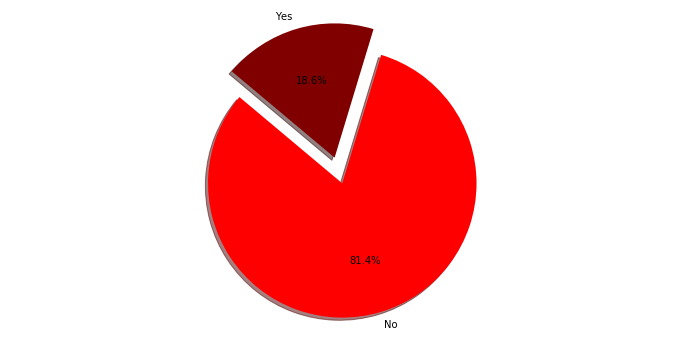

In [32]:
labels = album_purchases["album_purchase"]
sizes = album_purchases["num_invoices"]
colors = ["red", "maroon"]
explode = [0.1,0.1]
fig = plt.figure(figsize = (12,6))
plt.pie(sizes, explode =explode, labels = labels, colors = colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis("equal")
plt.show()